# scikit-learn-k-means

Credits: Forked from [PyCon 2015 Scikit-learn Tutorial](https://github.com/jakevdp/sklearn_pycon2015) by Jake VanderPlas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn; 
from sklearn.linear_model import LinearRegression
from scipy import stats
import pylab as pl

seaborn.set()

## 1. K-Means Clustering

In [2]:
from sklearn import neighbors, datasets
from sklearn.decomposition import PCA
import pylab as pl

Reduced dataset shape: (150, 2)
Meaning of the 2 components:
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


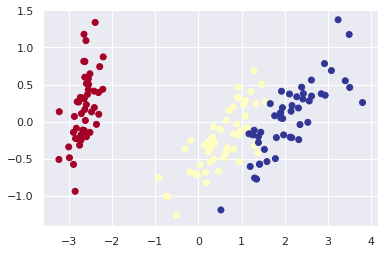

In [3]:
iris = datasets.load_iris()
X, y = iris.data, iris.target

# PCA降维
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
print("Reduced dataset shape:", X_reduced.shape)


pl.scatter(X_reduced[:, 0], 
           X_reduced[:, 1], 
           c=y,
           cmap='RdYlBu')


# PCA 降维后的
print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

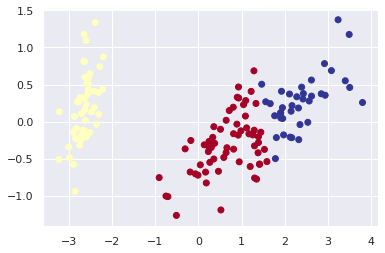

In [4]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0) # Fixing the RNG in kmeans
k_means.fit(X)
y_pred = k_means.predict(X)

pl.scatter(X_reduced[:, 0], 
           X_reduced[:, 1], 
           c=y_pred,
           cmap='RdYlBu');

## 2.  Expectation Maximization (EM) 

K Means is an algorithm for **unsupervised clustering**: that is, finding clusters in data based on the data attributes alone (not the labels).

K Means is a relatively easy-to-understand algorithm.  It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.


** Let's look at how KMeans operates on the simple clusters we looked at previously. To emphasize that this is unsupervised, we'll not plot the colors of the clusters: **

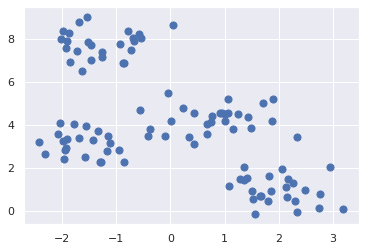

In [5]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=100, 
                  centers=4,
                  random_state=0, 
                  cluster_std=0.60)

plt.scatter(X[:, 0], 
            X[:, 1], 
            s=50)

By eye, it is relatively easy to pick out the four clusters. If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points. Fortunately, there is a well-known **Expectation Maximization (EM)** procedure which scikit-learn implements, so  that KMeans can be solved relatively quickly.

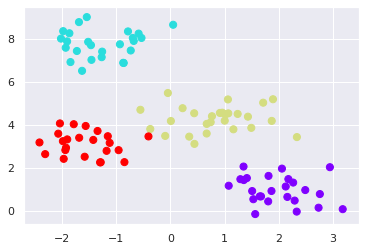

In [6]:
from sklearn.cluster import KMeans

est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], 
            X[:, 1], 
            c=y_kmeans, 
            s=50,
            cmap='rainbow');

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

## The K-Means Algorithm: Expectation Maximization

K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.
*Expectation-Maximization* is a two-step approach which works as follows:

1. Guess some cluster centers
2. Repeat until converged
A. Assign points to the nearest cluster center
B. Set the cluster centers to the mean 
   
Let's quickly visualize this process:

This algorithm will (often) converge to the optimal cluster centers.

Credits: Forked from [Matplotlib_animation](https://github.com/leeroee/Matplotlib_animation) by Leeroee.

--- loop 0 ---
--- loop 1 ---
--- loop 2 ---
--- loop 3 ---
--- loop 4 ---
--- loop 5 ---
--- loop 6 ---
--- loop 7 ---


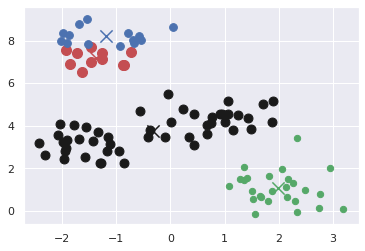

In [11]:
from matplotlib.animation import FuncAnimation  # 动画函数

class KMeans(object):
    
    def __init__(self, data):
        self.data = data
        
        # 自定义ufunc，将所有样本分类
        self.calc_classes = np.frompyfunc(          
            self.calc_distance, 
            data.shape[1], 1)
        
        self.fig, self.ax = plt.subplots()
        

    def calc_distance(self, *features):
        '''
        计算样本与每个中心的距离并将其归于最近的一类
        '''
        x = np.array(features)   
        return np.argmin(np.square(self.center - x).sum(axis=1))


    def clustering(self, k):
        self.k = k
        self.sizes = np.linspace(40, 100, num=k)
        
        # 随机初始k个簇中心
        choices = np.random.randint(0, self.data.shape[0], size=k) 
        self.center = np.copy(self.data[choices])  
        
        # [# 设置动画，帧回调函数，帧数，动画初始化，每帧间隔]
        anim = FuncAnimation(self.fig,  
                func=self.update,      
                frames=np.arange(8),    
                init_func=self.setup,  
                interval=1000)          
        anim.save('kmeans-clustering.gif', dpi=80, writer='pillow')


        
    def setup(self, colors=['r', 'g', 'b', 'k']):
        '''
        动画初始化函数
        '''
        cs = self.get_classified_sample()
        
        tmp = []
        for i in np.arange(self.k):     # 绘制已分类的样本
            tmp.append(self.ax.scatter(cs[i][:,0], cs[i][:,1], c=colors[i], animated=True))

        for i in np.arange(self.k):     # 绘制中心
            tmp.append(self.ax.scatter(self.center[i,0], self.center[i,1], c=colors[i], s=150, marker='x', animated=True))
        
        self.sc = tuple(tmp)           
        for i in np.arange(self.k):     # 更新每个簇的中心
            self.center[i,:] = cs[i].mean(axis=0)

        return self.sc    


    def get_classified_sample(self):
        '''
        将所有样本分为k类
        返回一个列表，列表中的每个元素是被归于同一类的样本
        '''
        cols = list(self.data.T)
        self.classes = self.calc_classes(*cols)     # 计算所有样本的类别
        return [self.data[self.classes==i] for i in np.arange(self.k)]


    def update(self, j):
        print('--- loop {} ---'.format(j))
        cs = self.get_classified_sample()

        for i in np.arange(self.k):
            self.sc[i].set_offsets(cs[i])                       # 更新每个簇的点的坐标
            self.sc[i]._sizes[0] = self.sizes[(i+j) % self.k]   # 动态调增点的大小，增加视觉对比
            self.sc[i+self.k].set_offsets(self.center[i])       # 更新每个簇中心的坐标


        for i in np.arange(self.k):         # 更新每个簇的中心
            self.center[i,:] = cs[i].mean(axis=0)

        return self.sc      # 返回必须是元组

    
    
if __name__ == "__main__":
    km = KMeans(X)
    km.clustering(4)